In [1]:
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
from orbithunter.physics_ks import shadowing
import numpy as np
import matplotlib.pyplot as plt
from math import pi

This notebook walksthough the basics of the orbithunter package, for the implementation by Matthew Gudorf for the spatiotemporal Kuramoto-Sivashinsky equation (the original purpose/foundation).

# orbithunter

The point of this package is to provide an interface and framework for solving chaotic, nonlinear partial differential equations in a spatiotemporal manner which does not have the pitfall of exponentially dynamical instabilities, because there are no dynamics. The unstable PDE, which is typically solve in terms of spatial Fourier modes as tower of ODEs, is replaced in full by a system of differential algebraic equations. This formulation allows the equations to determine the spatiotemporal
domain size (including spatial dimensions) instead of fixing them. This is believed to be a much more natural representation because of invariance to spatiotemporal translations.

This walkthrough demonstrates the user friendliness of the orbithunter package as well as its utility in finding ("unstable") periodic orbits of the Kuramoto-Sivashinsky equation. 

### Introduction to the OrbitKS class and its subclasses.

Each spatiotemporal solution to the KSE is a scalar spatiotemporal velocity field $u(t,x)$ which satisfies the equation
\begin{equation}
F(u) = u_t + u_{xx}+ u_{xxxx} + \frac{1}{2}\partial_x u^2 = 0
\end{equation}

These solutions, or initial conditions with which to find solutions, are represented via Python class objects (object oriented programming). There are a number of symmetries that the solutions are equivariant under, meaning that the application of the group operations maintain a scalar field's status as a solution. These objects represent two dimensional discretizations of $u$. orbithunter takes the opinion that to exactly define a solution the following information is required: the spatiotemporal dimensions of the spatiotemporal domain or 'tile', the discretization size, and the field values corresponding to this discretization size.


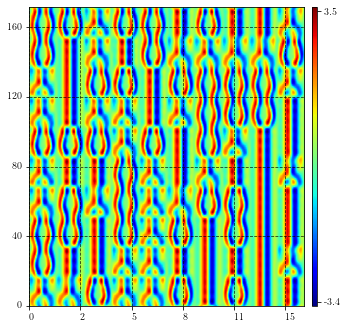

In [2]:
test = read_h5('OrbitKS_bigtiling.h5', directory='../data/local/testing/')
test.plot(save=True, filename='OrbitKS_bigtiling_initial.h5', directory='../data/local/testing/')

In [3]:
test = read_h5('OrbitKS_large_TL.h5', directory='../data/local/thesis/')

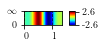

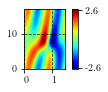

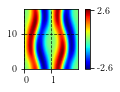

In [17]:
from orbithunter.gluing import tile_dictionary_ks
td = tile_dictionary_ks(padded=False, comoving=True)
td[0].plot()
td[1].plot()
td[2].plot()

In [18]:
from orbithunter.physics_ks import energy

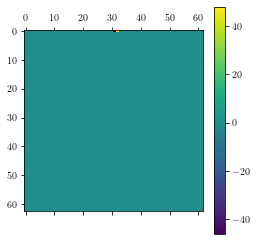

In [29]:
plt.matshow(td[0].convert(to='modes').state)
plt.colorbar()

In [33]:
td[0]

OrbitKS({"basis": "field", "parameters": ["0.0", "12.0", "0"], "field_shape": ["64", "64"]})

In [36]:
td[0].convert(to='modes').state[0,-31:]

array([2.12883519e+03, 2.29785289e+03, 4.13869991e+01, 1.97276210e+00,
       2.83160987e-02, 5.66319247e-04, 7.65265730e-06, 1.11327781e-07,
       1.38921111e-09, 1.73397072e-11, 2.02020430e-13, 2.31328409e-15,
       2.55255398e-17, 2.76552817e-19, 3.01294663e-21, 8.33234331e-30,
       7.09974815e-30, 1.59744333e-29, 4.21824880e-29, 3.82894132e-30,
       2.75730846e-29, 3.95436300e-31, 5.64190814e-30, 3.00849923e-31,
       3.87746502e-30, 9.23591742e-31, 5.37122602e-30, 5.43574468e-30,
       1.59744333e-29, 0.00000000e+00, 0.00000000e+00])

In [25]:
(td[0].convert(to='modes')**2).state.sum()

4470.076726609392

In [24]:
(td[1].convert(to='modes')**2).state.sum()

2101.3940090704627

In [22]:
(td[2].convert(to='modes')**2).state.sum()

4280.714367024226

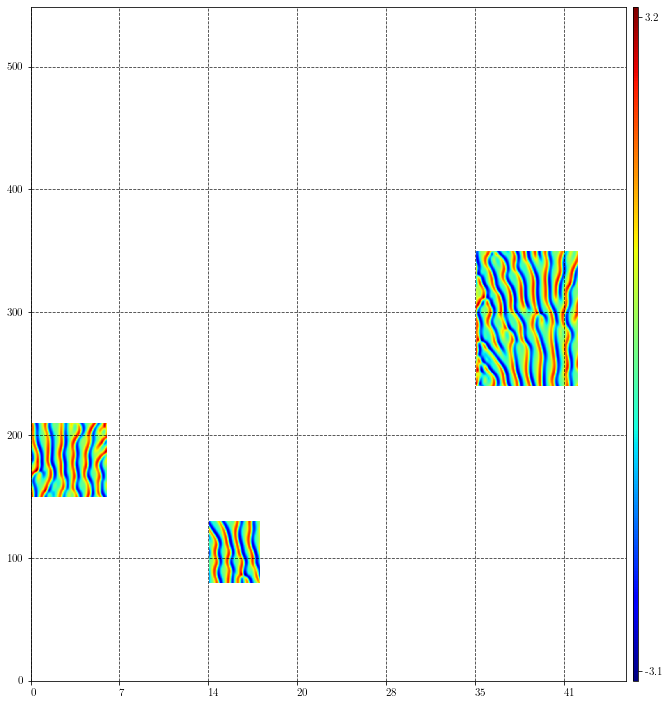

In [15]:
windows = [((150,210),(0,6)), ((80,130),(14,18)), ((240, 350),(35,43))]

mask_orbit(test, windows).plot()

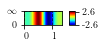

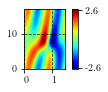

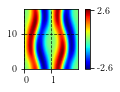

In [4]:
m = read_h5('RelativeOrbitKS_T15p855_L13p026.h5', directory='../data/tiles/original/').reshape(64, 64)
shift = m.S
from orbithunter.gluing import tile_dictionary_ks
td = tile_dictionary_ks(padded=False, comoving=True)
td[0].plot()
td[1].plot()
td[2].plot()

In [17]:
integrated_trajectory = OrbitKS(seed=0, parameters=(32*td[1].T, 32*td[1].L), M=1024)
for segments in range(0, 100):
    integrated_trajectory = kse_integrate(integrated_trajectory, integration_time=10000, verbose=True,
                                          starting_point=0, step_size=0.25, return_trajectory=False)

Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [#########################]Integration progress [##################

In [18]:
integrated_trajectory = kse_integrate(integrated_trajectory, integration_time=32*td[1].T,
                                          starting_point=0, step_size=0.25, verbose=True)

Integration progress [##########################]

In [19]:
integrated_trajectory.to_h5('incredibly_long_transient_integration.h5', directory='../data/local/testing')

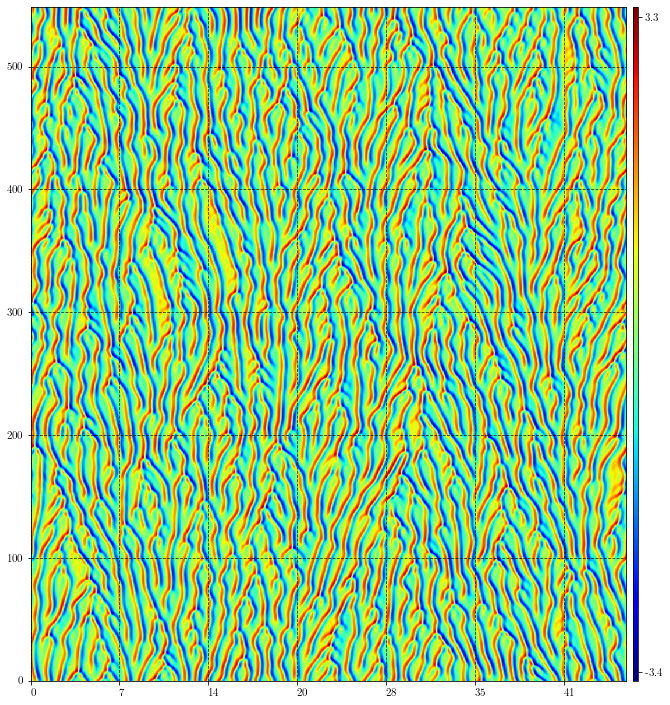

In [13]:
integrated_trajectory.plot()

In [31]:
m = read_h5('RelativeOrbitKS_T15p855_L13p026.h5', directory='../data/tiles/original/').reshape(64, 64).convert(to='field')

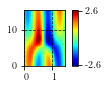

In [28]:
mfd = m.convert(to='field').change_reference_frame(to='physical').copy()
mfd.plot(padding=False)

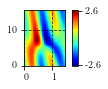

In [33]:
mcml = m.reflection().copy()
mcml.plot(padding=False, fundamental_domain=False)

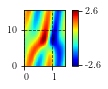

In [30]:
mcmr = m.copy()
mcmr.plot(padding=False, fundamental_domain=False)

In [35]:
shadow_mfd = shadowing(mfd, integrated_trajectory, norm_percentile=0.03)
shadow_mcmr = shadowing(mcmr, integrated_trajectory, norm_percentile=0.03)
shadow_mcml = shadowing(mcml, integrated_trajectory, norm_percentile=0.03)

In [56]:
mask = np.logical_or(shadow_mfd[1], np.logical_or(shadow_mcmr[1], shadow_mcml[1]))

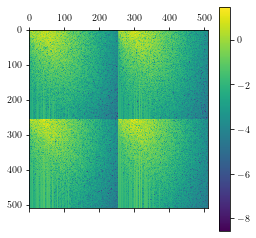

In [75]:
_ = plt.matshow(np.log10(np.abs(integrated_trajectory.convert(to='modes').reshape(512,512).state)))
_ = plt.colorbar()
_ = plt.show()

In [58]:
masking_orbit = integrated_trajectory.copy()
masked_large_trajectory = integrated_trajectory.copy()
masking_orbit.state = mask.astype(int)
masked_large_trajectory.state[mask==False] = np.nan

In [59]:
masking_orbit.to_h5(filename='OrbitKS_masking.h5', directory='../data/local/thesis/')

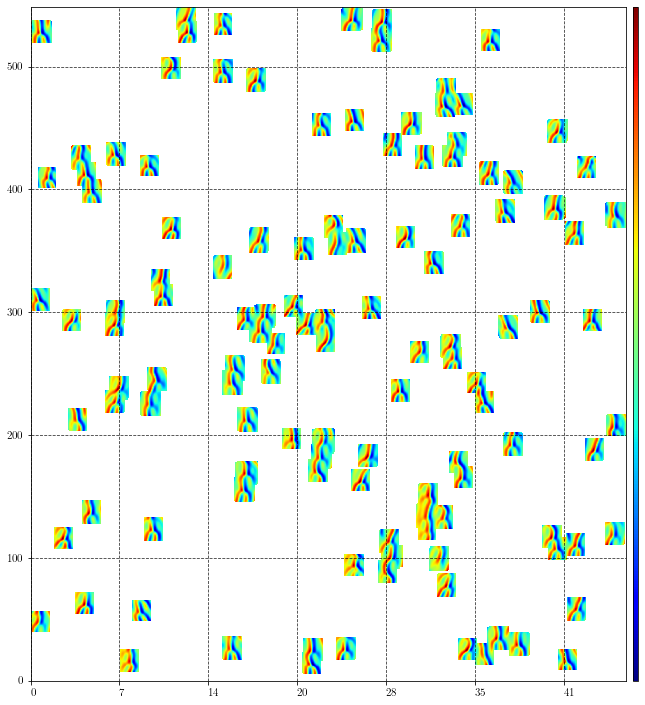

In [63]:
masked_large_trajectory.plot(filename='OrbitKS_masked_large_TL.h5', padding=False, directory='../data/local/thesis/')

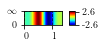

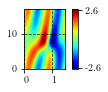

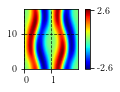

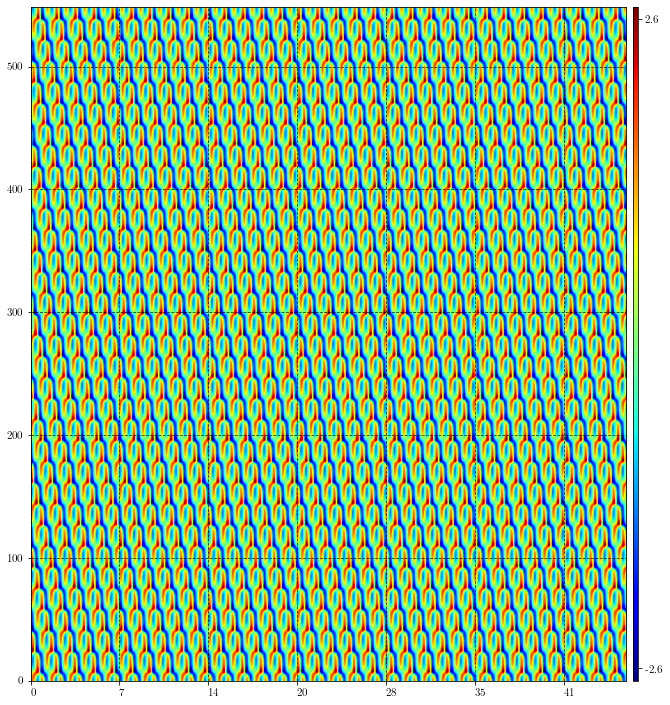

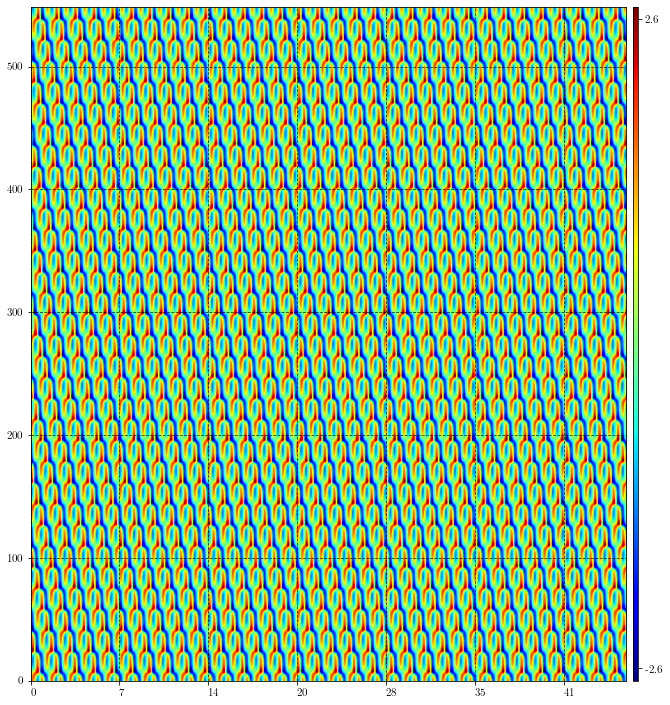

In [74]:
m = read_h5('RelativeOrbitKS_T15p855_L13p026.h5', directory='../data/tiles/original/')
shift = m.S

from orbithunter.gluing import tile_dictionary_ks
td = tile_dictionary_ks(padded=False, comoving=True)
td[0].plot()
td[1].plot()
td[2].plot()

symbol_array = np.array([[0, 1], [2, 2], [1, 0]])
tiled_orbit = tile(np.ones([32,32]), td, RelativeOrbitKS, stripwise=False)
tiled_orbit.S = 32 * shift
tiled_orbit.plot(filename='defect_tiling_32b32.png')
tiled_orbit.plot(filename='defect_tiling_32b32.pdf')

The idea is "simple" instead of describing chaotic nonlinear pdes as
exponentially unstable dynamical systems (initial value problem) it is instead treated as a $(D+1)$ dimensional boundary value problem. This work only uses variational methods; time integration is possible but it is in no way involved
in the optimization or any other process.

In [ ]:

symbol_array = np.array([[0, 1], [2, 2], [1, 0]])
tiled_orbit = tile(np.ones([32,32]), td, RelativeOrbitKS, stripwise=False)
tiled_orbit.plot()